In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
import exmol as exmol
from rdkit.Chem.Draw import rdDepictor
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve
os.environ["CUDA_VISIBLE_DEVICES"]="0"
rdDepictor.SetPreferCoordGen(True)

IPythonConsole.ipython_useSVG = True
# sns.set_context('notebook')
# sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = [ '#F06060', '#1BBC9B','#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')

In [2]:
# make object that can compute descriptors
calc = Calculator()
calc.register([HydrogenBond.HBondDonor, HydrogenBond.HBondAcceptor])
calc.register([AcidBase.AcidicGroupCount, AcidBase.BasicGroupCount,
            Aromatic.AromaticBondsCount])
calc.register([SLogP.SLogP, Polarizability.APol,  BertzCT.BertzCT])
calc.register([BondCount.BondCount(type='double'),
            BondCount.BondCount(type='aromatic')])

# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in soldata.SMILES]

raw_features = []
for e, c in zip(molecules, calc.map(molecules, quiet=True)):
    raw_features.append([v for v in c.values()])
feature_names = np.array([d.description() for d in calc.descriptors])


In [3]:
raw_features = np.array(raw_features)

In [4]:
# feature_names = soldata.columns[features_start_at:]
# raw_features = soldata[feature_names]
labels = soldata['Solubility']

In [5]:
def pick_features(raw_features):
    fm = raw_features.mean()
    fs = raw_features.std()
    def feature_convert(f):
        f -= fm
        f /= fs
        return f

    features = feature_convert(raw_features)

    # we have some nans in features, likely because std was 0
    features = features.astype(float)
    features_select = np.random.randint(0, len(raw_features[0]), size=3) # np.all(np.isfinite(features), axis=0)
    features = features[:, features_select]
    names = feature_names[features_select]
    return features, names

In [6]:
features, names = pick_features(raw_features)
print(features.shape, names)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, shuffle=True)

clf = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

(9982, 3) ['Wildman-Crippen LogP' 'number of hydrogen bond donor'
 'basic group count']


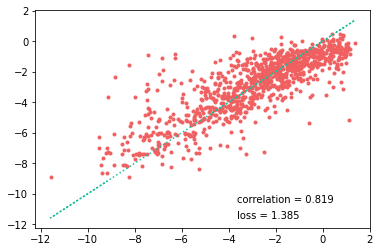

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, shuffle=True)

clf = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
plt.plot(y_test, predicted, '.')
plt.plot(y_test, y_test, linestyle=':')
plt.text(max(y_test) - 5, min(y_test) + 1, f'correlation = {np.corrcoef(y_test, predicted)[0,1]:.3f}')
plt.text(max(y_test) - 5, min(y_test), f'loss = {np.sqrt(np.mean((y_test - predicted)**2)):.3f}')
plt.savefig('RF-ROC.png')

In [8]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    # calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
    # raw_features = calc.pandas(molecules, nproc=8, quiet=True)
#     features = feature_convert(raw_features)
#     features = features.astype(float)
#     features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
labels = model_eval(soldata.SMILES, features) #.values[:100])

In [29]:
smi = soldata.SMILES[1000]
space = exmol.sample_space(smi, model_eval, num_samples=2000)

🤘Done🤘: 100%|██████████| 947.0/947 [00:01<00:00, 908.52it/s]                        


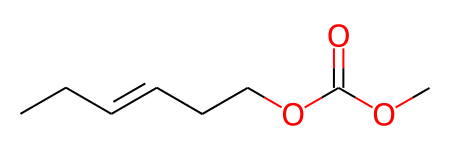

In [30]:
mol = rdkit.Chem.MolFromSmiles(smi)
mol

## Compare Feature significance to linear regression

In [31]:
def calc_feature_importance(descriptors, tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(descriptors, tstats)}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

def linear_model_tstats(x_mat, y, w=None):
    from sklearn.linear_model import LinearRegression
    noisey_x_mat = (x_mat +
                    np.random.uniform(-1e-4, 1e-4,
                                      size=x_mat.shape)) #* w[:, np.newaxis]
    model = LinearRegression(fit_intercept=False).fit(noisey_x_mat, y)
    xtinv = np.linalg.inv(noisey_x_mat.T @ noisey_x_mat)
    beta = model.coef_
    yhat = model.predict(x_mat)
    resids = yhat - y
    SSR = np.sum(resids**2)
    se2_epsilon = SSR / (len(examples) - len(beta))
    se2_beta = se2_epsilon * xtinv
    # now compute t-statistic for existence of coefficients
    tstat = beta * np.sqrt(1 / np.diag(se2_beta))
    lr_importance = calc_feature_importance(descriptors, tstat.flatten())
    return lr_importance



In [32]:
# Linear regression on features
descriptor_type='Classic'
examples = exmol.get_descriptors(space, descriptor_type)
descriptors = list(examples[0].descriptors.descriptor_names)

x_mat = np.array([list(e.descriptors.descriptors)
                  for e in examples]).reshape(len(examples), -1)
# remove zero variance columns
y = np.array([e.yhat for e in examples]).reshape(len(examples), -1).astype(float)

In [49]:
lr_attr = linear_model_tstats(x_mat, y)

In [33]:
wls_tstats, wls_beta = exmol.lime_explain(space, descriptor_type=descriptor_type)
wls_attr = calc_feature_importance(list(space[0].descriptors.descriptor_names), wls_tstats)
wls_attr

{'Wildman-Crippen LogP': -1.0733148208718952,
 'number of hydrogen bond donor': 0.7646373259591396,
 'Bertz CT': 0.7286092194576852,
 'basic group count': -0.6531393396809488,
 'number of double bonds in non-kekulized structure': -0.48547394138250743,
 'atomic polarizability': 0.24198725451890005,
 'acidic group count': 0.14523994681055996,
 'number of hydrogen bond acceptor': -0.09547248083458043,
 'aromatic bonds count': -5.9944169387273373e-05,
 'number of aromatic bonds in non-kekulized structure': -5.994416938727318e-05}

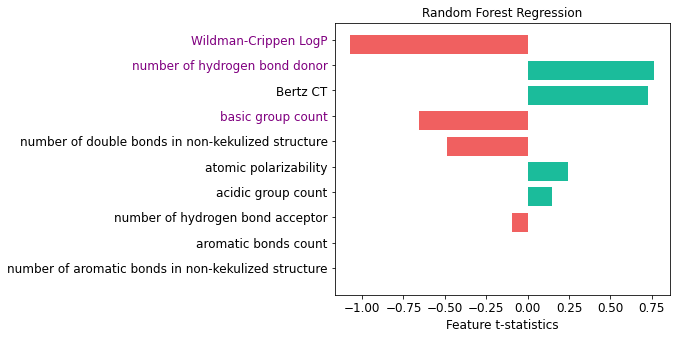

In [46]:
x = (wls_attr.keys())
xaxis = np.arange(len(x))
x_colors = ['purple' if t in names else 'black' for t in x]

rf_imp = {a:b for a, b in zip(names, clf.feature_importances_)}
rf_x = np.zeros(len(x))
rf_y = np.zeros(len(x))
for i, j in enumerate(x):
    if j in rf_imp:
        rf_x[i] = i
        rf_y[i] = rf_imp[j]
      
width = [wls_attr[i] for i in x]
colors = ['#F06060' if i<0 else '#1BBC9B' for i in width]

fig, ax = plt.subplots(figsize=(6,5))
# plt.barh(xaxis-0.2, [lr_attr[i] for i in x], 0.4, label='LR')
ax.barh(xaxis+0.2, width, 0.75, label='WLS', color = colors)
# plt.barh(rf_x-0.4, rf_y, 0.4, label='RF model')

plt.xticks(fontsize=12)
plt.xlabel('Feature t-statistics', fontsize=12)
plt.yticks(xaxis, x, fontsize=12)
[t.set_color(i) for (i,t) in
 zip(x_colors, ax.yaxis.get_ticklabels())]
plt.gca().invert_yaxis()
# plt.legend()
plt.title('Random Forest Regression', fontsize=12)
plt.savefig('baseline.svg', bbox_inches='tight', dpi=180)

[-2.279459959752991, 1.820738052044855, -1.5618876259080507, -1.284787576208102, 0.9798329975423786]


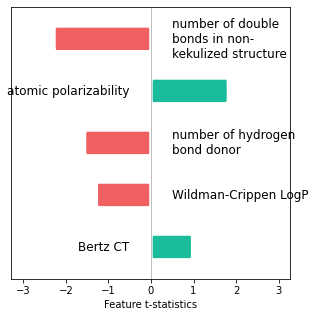

In [20]:
plot_desc(wls_attr, output_file='RF.svg')

In [19]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
def plot_desc(feature_importance, output_file, title=None, ax = None):
    if ax is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    if len(t) > 0:
        if len(t) > 5:
            t = t[:5]
            keys = keys[:5]
            print(t)
        elif len(t) < 5:
            diff = 5 - len(t)
            for i in range(diff):
                t.append(0)
                keys.append(' ')
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.75)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        count = 1
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 20)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.5
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=12)
                count+=1
            else:
                x = -0.5
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=12)
                count+=1
            
        ax.set_xlim(-np.max(np.absolute(t))-1, np.max(np.absolute(t))+1)
    else:
        patch = ax.get_ylim()
        print(patch)
        ax.text(0.5, 0.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=12)
    
    
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_xlabel('Feature t-statistics')
    ax.set_title(title)
    if output_file is not None:
        plt.savefig(output_file, dpi = 300, bbox_inches='tight')